In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Import necessary libraries**

In [2]:
import nltk
import re
import csv

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import bq_helper
from bq_helper import BigQueryHelper

import warnings
warnings.filterwarnings('ignore', message=r'Label not .* is present in all training examples.')

pd.set_option('display.max_colwidth', 300)


In [3]:
from google.cloud import bigquery
import tensorflow as tf
import string
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron


from sklearn.metrics import f1_score, accuracy_score

**Select Kaggle public datasets**

In [5]:
stack_overflow = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                         dataset_name="stackoverflow")

Using Kaggle's public dataset BigQuery integration.


**Searching for an appropriate dataset**

In [6]:
bg = BigQueryHelper("bigquery-public-data", "stackoverflow")
bg.list_tables()

Using Kaggle's public dataset BigQuery integration.


['badges',
 'comments',
 'post_history',
 'post_links',
 'posts_answers',
 'posts_moderator_nomination',
 'posts_orphaned_tag_wiki',
 'posts_privilege_wiki',
 'posts_questions',
 'posts_tag_wiki',
 'posts_tag_wiki_excerpt',
 'posts_wiki_placeholder',
 'stackoverflow_posts',
 'tags',
 'users',
 'votes']

In [7]:
bg.head("stackoverflow_posts", num_rows=1)



,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,376158,None,<p>Assuming // do something is more than just the comment take out the </p> <p>// do something </p> <p>code and see if it still crashes. Add stuff back one at a time till it crashes again</p>,None,None,0,None,2008-12-17 21:52:23.097000+00:00,None,2008-12-17 21:52:23.097000+00:00,None,None,None,n8wrl,37710,361115,2,0,,None


**Query Stack_Overflow_posts and select relevant columns**

In [8]:
query = """
        SELECT 
            id, title , tags 
        FROM 
            `bigquery-public-data.stackoverflow.stackoverflow_posts`
        WHERE
            title NOT LIKE '%None%' AND 
            (tags LIKE '%|python|%' OR tags LIKE '%|c#|%' OR
            tags LIKE '%|java|%' OR tags LIKE '%|r|%' OR
            tags LIKE '%|android|%' OR tags LIKE '%|html|%' OR
            tags LIKE '%|c++|%' OR tags LIKE '%|sql|%' OR
            tags LIKE '%|c|%' OR tags LIKE '%kotlin%') AND 
            LENGTH(tags) < 20
        LIMIT
             20000;
        """

data = stack_overflow.query_to_pandas(query)

data_copy = data.copy()

data.head()

,id,title,tags
0,36545772,webview from assets with multipages,java|android|html
1,33571287,How to find which items from a list are not in a table using SQLAlchemy,python|sql|sqlite
2,28677991,What stops me from using dependencies of dependencies in an Android app?,java|android|gradle
3,34005234,SSL Peer Exception on APK and Stock Browser,java|android|ssl
4,35492042,NFC scans only once in application,java|android|nfc


**Preprocess the 'title' column by removing HTML tags, special characters, and converting to lowercase**

In [9]:
data.title = data.title.str.replace('<[^<]+?>','')
data.title = data.title.str.replace('http','')
data.title = data.title.str.replace('[^\w\s]','')
data.title = data.title.str.lower()
data.head()

,id,title,tags
0,36545772,webview from assets with multipages,java|android|html
1,33571287,how to find which items from a list are not in a table using sqlalchemy,python|sql|sqlite
2,28677991,what stops me from using dependencies of dependencies in an android app?,java|android|gradle
3,34005234,ssl peer exception on apk and stock browser,java|android|ssl
4,35492042,nfc scans only once in application,java|android|nfc


**Remove stopwords from the 'title' column**

In [10]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

data['title'] = data['title'].apply(lambda x: remove_stopwords(x))
data.head()

,id,title,tags
0,36545772,webview assets multipages,java|android|html
1,33571287,find items list table using sqlalchemy,python|sql|sqlite
2,28677991,stops using dependencies dependencies android app?,java|android|gradle
3,34005234,ssl peer exception apk stock browser,java|android|ssl
4,35492042,nfc scans application,java|android|nfc


**Split the 'tags' column into lists of tags**

In [11]:
data['tags'] = data['tags'].str.split('|')
data.head()

,id,title,tags
0,36545772,webview assets multipages,"[java, android, html]"
1,33571287,find items list table using sqlalchemy,"[python, sql, sqlite]"
2,28677991,stops using dependencies dependencies android app?,"[java, android, gradle]"
3,34005234,ssl peer exception apk stock browser,"[java, android, ssl]"
4,35492042,nfc scans application,"[java, android, nfc]"


**Calculate the size of the 'tags' column**

In [12]:
# Assuming you have a DataFrame named 'df' and you want to get the size of the 'column_name' column
column_size = len(data['tags'])
print("Size of the column:", column_size)
data['tags']

Size of the column: 20000


0          [java, android, html]
1          [python, sql, sqlite]
2        [java, android, gradle]
3           [java, android, ssl]
4           [java, android, nfc]
                  ...           
19995    [java, android, sqlite]
19996    [java, android, sqlite]
19997    [java, android, sqlite]
19998    [java, android, sqlite]
19999    [java, android, sqlite]
Name: tags, Length: 20000, dtype: object

**Create a Word Cloud of the tags**

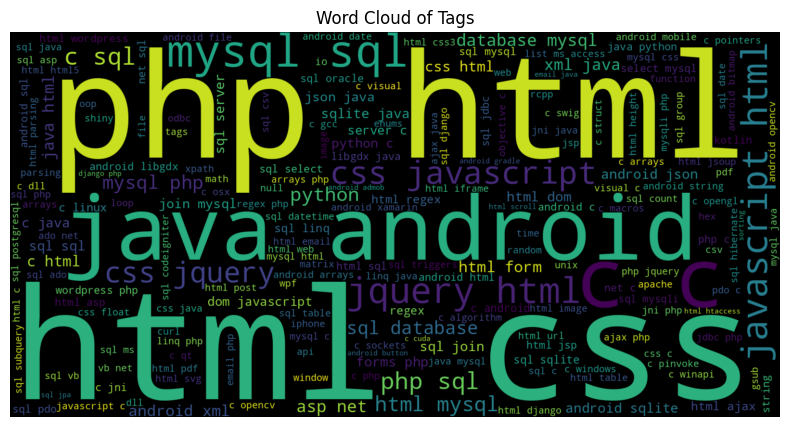

In [13]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_tags = [tag for tags_list in data['tags'] for tag in tags_list]

# Convert the tags to strings and join them into a space-separated string
tags_text = ' '.join(map(str, all_tags))

# Create a WordCloud object with desired settings
wordcloud = WordCloud(width=1600, height=800, background_color='black').generate(tags_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.title("Word Cloud of Tags")
plt.show()

**Create a bar graph for the frequency of top 50 tags**

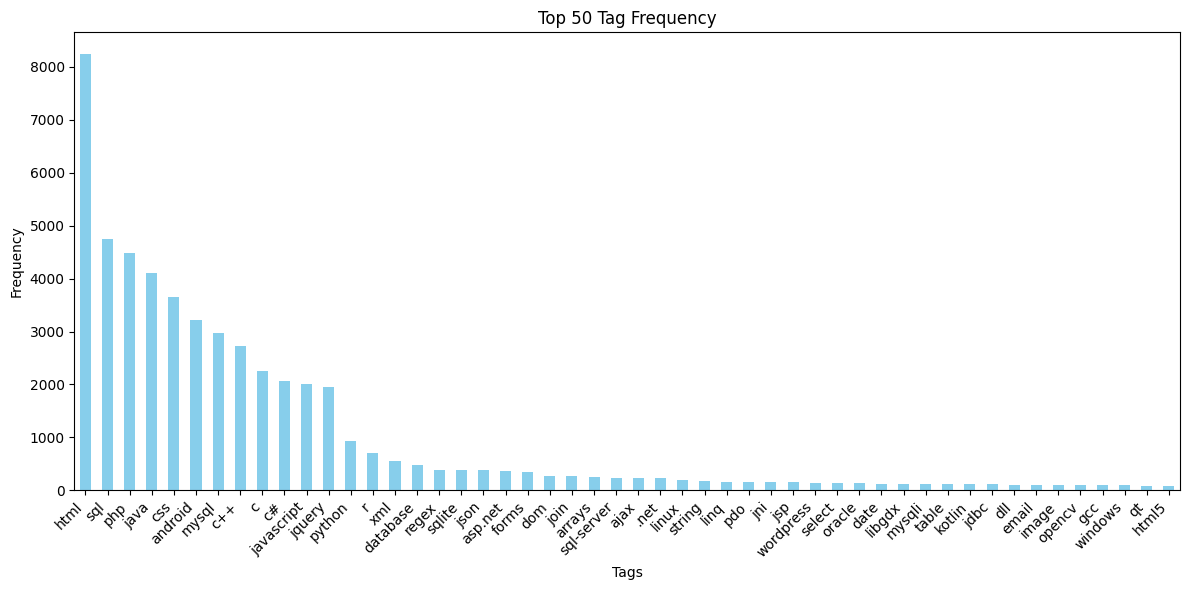

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Flatten the lists of tags into a single list of tags
all_tags = [tag for tags_list in data['tags'] for tag in tags_list]

# Create a Pandas Series and count the occurrences of each tag
tag_counts = pd.Series(all_tags).value_counts()
# Select the top 50 most occurring tags
top_tags = tag_counts.head(50)

# Create a bar graph for the top 50 tags
plt.figure(figsize=(12, 6))
top_tags.plot(kind='bar', color='skyblue')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Top 50 Tag Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

**Preparing target variable**

**Create a MultiLabelBinarizer to convert tags to binary format**

In [15]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(data['tags'])

y = multilabel_binarizer.transform(data['tags'])

**Split the data into training and validation sets**

In [16]:
x_train, x_val, ytrain, yval = train_test_split(data['title'],y, test_size=0.2,random_state = 0)

**Create a TF-IDF vectorizer**

In [17]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=1, max_features=5000)
xtrain = tfidf_vectorizer.fit_transform(x_train)
xval = tfidf_vectorizer.transform(x_val)

**Training Models and checking their F1 score and Accuracy**

In [18]:
lr = LogisticRegression()
classifier = OneVsRestClassifier(lr)
classifier.fit(xtrain, ytrain)

OneVsRestClassifier(estimator=LogisticRegression())

In [19]:
y_pred = classifier.predict(xval)
f1_score(yval, y_pred, average="micro"), accuracy_score(yval, y_pred)

(0.5777149997283643, 0.0835)

In [20]:
perceptron = Perceptron()
classifier = OneVsRestClassifier(perceptron)
classifier.fit(xtrain, ytrain)


OneVsRestClassifier(estimator=Perceptron())

In [21]:
y_pred = classifier.predict(xval)
f1_score(yval, y_pred, average="micro"), accuracy_score(yval, y_pred)

(0.5400015052306767, 0.0925)

In [22]:
svc = LinearSVC()
classifier = OneVsRestClassifier(svc)
classifier.fit(xtrain, ytrain)

OneVsRestClassifier(estimator=LinearSVC())

**In this case of Multi-Label Classification LinearSVC classifier had higher accuracy than other models so it is used for furthur predictions**

In [23]:
y_pred = classifier.predict(xval)
f1_score(yval, y_pred, average="micro"), accuracy_score(yval, y_pred)

(0.6539039402898269, 0.165)

In [24]:
pred_prob = classifier.predict(xval)
t = 0.2
predp = (pred_prob >= t).astype(int)
f1_score(yval, predp, average="micro"), accuracy_score(yval, predp)

(0.6539039402898269, 0.165)

**Define a function to make predictions on custom input**

In [25]:
def predict(m):
    m = remove_stopwords(m)
    m_vec = tfidf_vectorizer.transform([m])
    pred_prob = classifier.predict(m_vec)
    t = 0.3
    predp = (pred_prob >= t).astype(int)
    return multilabel_binarizer.inverse_transform(predp)

**Make predictions on 10 random validation set samples**

In [26]:
for i in range(10):
    k = x_val.sample(1).index[0]
    print("Title: ", data_copy['title'][k],
          "\nPredicted tags: ", predict(x_val[k])),
    print("Actual tags: ",data['tags'][k], "\n")

Title:  java.lang.NullPointerException when trying to access SQLite database 
Predicted tags:  [('android', 'java', 'sql', 'sqlite')]
Actual tags:  ['java', 'android', 'xml'] 

Title:  Insert in sqlite doesn't work 
Predicted tags:  [('android', 'sqlite')]
Actual tags:  ['java', 'android', 'sqlite'] 

Title:  how to write path for files in sibling folders? 
Predicted tags:  [('html',)]
Actual tags:  ['javascript', 'html', 'css'] 

Title:  Can you get something like C #define for functions in C# 
Predicted tags:  [('c', 'c++')]
Actual tags:  ['c#', 'c', 'macros'] 

Title:  CSS causing xml to be positioned out of line 
Predicted tags:  [('css', 'html', 'javascript', 'xml')]
Actual tags:  ['asp.net', 'html', 'css'] 

Title:  Macro to count (character) arguments 
Predicted tags:  [('c', 'c++', 'macros')]
Actual tags:  ['c++', 'c', 'macros'] 

Title:  Assign char array to another char array 
Predicted tags:  [('arrays', 'c', 'c++')]
Actual tags:  ['c++', 'c', 'arrays'] 

Title:  How to prin

**Predicting tag of a User Input**

In [27]:
custom_input = "how to sort an array"

predictions = predict(custom_input)

print("Predicted Class Labels:", predictions)

Predicted Class Labels: [('arrays', 'c++', 'sorting')]


**Saving the model**

In [28]:
import pickle
with open("classifier.pkl", "wb") as f:
    pickle.dump(classifier, f)
with open("stop.pkl", "wb") as f:
    pickle.dump(remove_stopwords, f)
with open("vect.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)
with open("multibin.pkl", "wb") as f:
    pickle.dump(multilabel_binarizer, f)

